# 1. Reading Data & EDA

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn import naive_bayes
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,classification_report

# plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# pre-difined functions from  @Leonardo Ferreira on Kaggle
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [3]:
csv_acc = './ACCIDENT/ACCIDENT.csv'
accident_raw = pd.read_csv(csv_acc)
csv_per = './ACCIDENT/PERSON.csv'
person_raw = pd.read_csv(csv_per)
csv_surf_con = './ACCIDENT/ROAD_SURFACE_COND.csv'
surface_raw = pd.read_csv(csv_surf_con)
csv_atmf_con = './ACCIDENT/ATMOSPHERIC_COND.csv'
atmospheric_raw = pd.read_csv(csv_atmf_con)
csv_veh = './ACCIDENT/VEHICLE.csv'
vehicle_raw = pd.read_csv(csv_veh)
csv_node = './ACCIDENT/NODE.csv'
node_raw = pd.read_csv(csv_node)

D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,25,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## REducing memory
accident_raw = reduce_mem_usage(accident_raw)
surface_raw = reduce_mem_usage(surface_raw)
atmospheric_raw = reduce_mem_usage(atmospheric_raw)
# node_raw = reduce_mem_usage(node_raw)
person_raw = reduce_mem_usage(person_raw)
vehicle_raw = reduce_mem_usage(vehicle_raw)

Mem. usage decreased to 21.30 Mb (44.6% reduction)
Mem. usage decreased to  3.11 Mb (43.7% reduction)
Mem. usage decreased to  3.14 Mb (43.7% reduction)
Mem. usage decreased to 45.58 Mb (19.1% reduction)
Mem. usage decreased to 65.81 Mb (29.3% reduction)


In [5]:
# Map the lowering function to all column names
# accident_raw
accident_raw.columns = map(str.lower, accident_raw.columns)
accident_raw.columns = accident_raw.columns.str.replace(' ', '_')
# person_raw
person_raw.columns = map(str.lower, person_raw.columns)
person_raw.columns = person_raw.columns.str.replace(' ', '_')
# surface_raw
surface_raw.columns = map(str.lower, surface_raw.columns)
surface_raw.columns = surface_raw.columns.str.replace(' ', '_')
# atmospheric_raw
atmospheric_raw.columns = map(str.lower, atmospheric_raw.columns)
atmospheric_raw.columns = atmospheric_raw.columns.str.replace(' ', '_')
# node_raw
node_raw.columns = map(str.lower, node_raw.columns)
node_raw.columns = node_raw.columns.str.replace(' ', '_')
# vehicle_raw
vehicle_raw.columns = map(str.lower, vehicle_raw.columns)
vehicle_raw.columns = vehicle_raw.columns.str.replace(' ', '_')
# print(accident_sample.columns,surface_raw.columns,atmospheric_raw.columns,vehicle_raw.columns)

In [6]:
# set accidenttime into hour group
accident_raw['hour'] = accident_raw['accidenttime'].map(lambda x: str(x).split('.')[0])
# set accidentdate into month group
accident_raw['month'] = accident_raw['accidentdate'].map(lambda x: str(x).split('/')[1])
# set accidentdate into Year group
accident_raw['year'] = accident_raw['accidentdate'].map(lambda x: str(x).split('/')[2])

In [7]:
# # set up the target column is_sev_inj  (value is not 0 on no_persons_inj_2 or no_persons_killed)
# accident_raw['is_sev_inj'] = 0
# accident_raw.loc[accident_raw[['no_persons_inj_2','no_persons_killed']].T.sum() > 0,['is_sev_inj']] = 1
# accident_raw.shape

In [8]:
# node_raw.loc[node_raw['accident_no'].value_counts() > 1,:]
dup_node = node_raw[node_raw.accident_no.duplicated(keep=False)]
# print(dup_node.groupby(['accident_no','lat','long']).count().shape[0])
# print(dup_node.groupby(['accident_no']).count().shape[0])
# each accident_no only have one pair of lat & long, then drop duplicated rows
node_raw = node_raw[~node_raw.accident_no.duplicated(keep='first')]
# set Pedestrians vehicle_id
person_raw.loc[person_raw['vehicle_id'] == ' ',['vehicle_id']] = 'PD'
person_raw.loc[person_raw['road_user_type_desc'] == 'Pedestrians',['helmet_belt_worn']] = 0
# set whether person get serious injury
person_raw['is_sev_inj'] = 0
person_raw.loc[person_raw['inj_level'] < 3,['is_sev_inj']] = 1

In [9]:
print('-------------------Merging surface condition--------------------')

accident_full = accident_raw.merge(surface_raw,on='accident_no',sort=True)
acc_dup = accident_full[accident_full.accident_no.duplicated(keep=False)]
print('There are ',acc_dup.shape[0],' rows are duplicated.')
dup_acc_no = acc_dup.accident_no.unique()

# set up surface_cond to 99 (complex condition)
accident_full.loc[accident_full.accident_no.isin(dup_acc_no),'surface_cond'] = 99
accident_full.loc[accident_full.accident_no.isin(dup_acc_no),'surface_cond_desc'] = 'Mixed'

# drop duplicated rows only keep first one
accident_full = accident_full[~accident_full.accident_no.duplicated()]
print('After delete duplicated rows, there are ',accident_full.shape[0],' rows now.')


-------------------Merging surface condition--------------------
There are  2344  rows are duplicated.
After delete duplicated rows, there are  180084  rows now.


In [10]:
print('-------------------Merging atmospheric condition--------------------')

accident_full = accident_full.merge(atmospheric_raw,on='accident_no',sort=True)
acc_dup = accident_full[accident_full.accident_no.duplicated(keep=False)]
print('There are ',acc_dup.shape[0],' rows are duplicated.')
dup_acc_no = acc_dup.accident_no.unique()

# set up atmospheric_cond to 99 (complex condition)
accident_full.loc[accident_full.accident_no.isin(dup_acc_no),'atmosph_cond'] = 99
accident_full.loc[accident_full.accident_no.isin(dup_acc_no),'atmosph_cond_desc'] = 'Mixed'

# drop duplicated rows only keep first one
accident_full = accident_full[~accident_full.accident_no.duplicated()]
print('After delete duplicated rows, there are ',accident_full.shape[0],' rows now.')


-------------------Merging atmospheric condition--------------------
There are  5743  rows are duplicated.
After delete duplicated rows, there are  180084  rows now.


In [11]:

print('-------------------Merging node --------------------')
accident_full = accident_full.merge(node_raw,on='accident_no',sort=True)
accident_full = accident_full[~accident_full.accident_no.duplicated()]
print('After merge node data, there are ',accident_full.shape[0],' rows now.')

-------------------Merging node --------------------
After merge node data, there are  179250  rows now.


In [12]:
print('-------------------Merging person info --------------------')
accident_full = accident_full.merge(person_raw,on='accident_no',sort=True)
print('After merge node data, there are ',accident_full.shape[0],' rows now.')

-------------------Merging person info --------------------
After merge node data, there are  433094  rows now.


In [13]:
print('-------------------Merging vehicle info --------------------')
accident_full = accident_full.merge(vehicle_raw,on=['accident_no','vehicle_id'],how='left',sort=True)
# accident_full = accident_full[~accident_full.accident_no.duplicated()]
print('After merge node data, there are ',accident_full.shape[0],' rows now.')

-------------------Merging vehicle info --------------------
After merge node data, there are  433094  rows now.


In [14]:
accident_full['speed_zone'].unique()

array([ 60,  70, 100,  80,  50, 110,  90,  75,  40, 999, 888, 777,  30],
      dtype=int64)

In [15]:
# 777,888,999, are not correctly recorded, set them as other
accident_full['speed_zone'] = accident_full['speed_zone'].map(lambda x: 999 if x in [777,888,999] else x)
accident_full['speed_zone'].unique()

array([ 60,  70, 100,  80,  50, 110,  90,  75,  40, 999,  30], dtype=int64)

In [16]:
# adding percent on bar chart, ax: ax, total: total count
def label_pct(ax,total):
    for p in ax.patches:
        height = p.get_height()
        value = '{:1.2f}%'.format(height/total*100)
        ax.text(p.get_x()+p.get_width()/2.,height + 5,value,ha="center", fontsize=12)
        
# plot a line chart of sever data percentage        
def plt_pct(ax,df,x_name,y_name,order,y_label,base_line):
    tmp = pd.crosstab(df[x_name], df[y_name], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'not_severe', 1:'severe'}, inplace=True)
    ax = sns.pointplot(x=x_name, y='severe', data=tmp, color='red', order=order, legend=False)
    ax.set_ylabel(y_label, fontsize=14)
    ax.axhline(y=base_line, color='k', linestyle='--')
    ax.set_ylim([0,100])

# plot graphs vs target 
def plt_feature(df,feature,feature_label,no_total,base_line,target='is_sev_inj',ylim=[0,50000],legend_position=1):
    # overall figure
    plt.figure(figsize=(14,6))
    plt.suptitle(feature_label+' Distributions', fontsize=18)

    # first graph
    plt.subplot(121)
    ax_1 = sns.countplot(x=feature, data=df, order=display_order)
    ax_1.set_title(feature_label+" Distribution", fontsize=16)
    ax_1.set_xlabel(feature_label, fontsize=14)
    ax_1.set_ylabel("Count", fontsize=14)
    ax_1.set_ylim(ylim)
    label_pct(ax_1,no_total)

    # second graph
    plt.subplot(122)
    ax_2 = sns.countplot(x=feature, hue=target, data=df, order=display_order)
    plt.legend(title='Severe Injure', loc=legend_position, labels=['No', 'Yes'])
    ax_2.set_title(feature_label+" by Target(Is Severe)", fontsize=16)
    ax_2.set_xlabel(feature_label, fontsize=14)
    ax_2.set_ylabel("Count", fontsize=14)
    ax_2.set_ylim(ylim)

    # line graph on the second graph
    ax_22 = ax_2.twinx()
    plt_pct(ax_22,df,x_name=feature,y_name=target,order=display_order,y_label="% of Severe Injury",base_line=base_line)

In [17]:
# calculate the baseline
no_total_psn = accident_full.shape[0]
no_sev_inj_psn = accident_full.is_sev_inj.sum()
no_other_psn = no_total_psn - no_sev_inj_psn
pct_sev_inj_psn = no_sev_inj_psn/no_total_psn*100
print('Total person number: ',no_total_psn)
print('Total severe injury person number:', no_sev_inj_psn)
print(pct_sev_inj_psn, '% of the persons get severe injury')

Total person number:  433094
Total severe injury person number: 76535
17.6716832835366 % of the persons get severe injury


##### helmet_belt_worn codes:
1 Seatbelt worn 
2 Seatbelt not worn 
3 Child restraint worn 
4 Child restraint not worn 
5 Seatbelt/restraint not fitted 
6 Crash helmet worn 
7 Crash helmet not worn 
8 Not appropriate
9 Unknown
0 Pedestrians

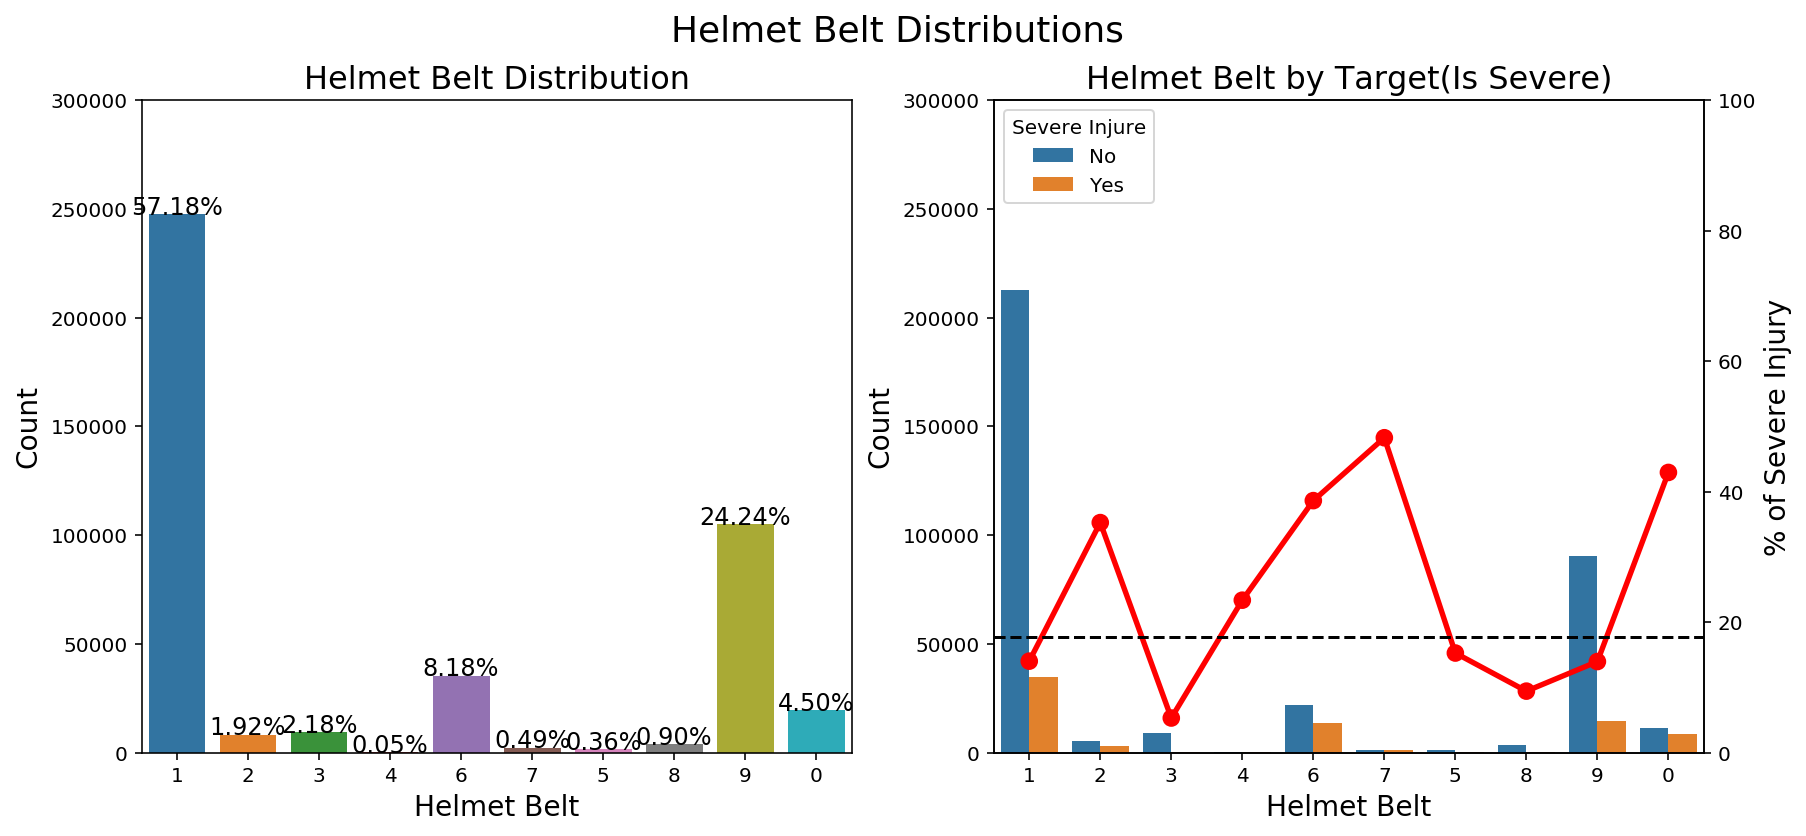

In [18]:
# belt/helmet analysis
display_order = [1,2,3,4,6,7,5,8,9,0]

feature = 'helmet_belt_worn'
feature_label = 'Helmet Belt'
plt_feature(accident_full,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,300000],legend_position=2)

In [19]:
# remove people does not wear helmet/belt  2,4,7,  8: not appropriate? assumption, not wear a correct way
# remove this to make a more accurate prediction only for people use helmet/belt correctly
# accident_belt = accident_full[~accident_full['helmet_belt_worn'].isin([2,4,7,8])]
# accident_belt.shape
accident_belt = accident_full

In [20]:
# calculate the baseline
no_total_psn = accident_belt.shape[0]
no_sev_inj_psn = accident_belt.is_sev_inj.sum()
no_other_psn = no_total_psn - no_sev_inj_psn
pct_sev_inj_psn = no_sev_inj_psn/no_total_psn*100
print('Total person number (Belt/Helmet on): ',no_total_psn)
print('Total severe injury person number (Belt/Helmet on):', no_sev_inj_psn)
print(pct_sev_inj_psn, '% of the persons who use Belt/Helmet get severe injury')

Total person number (Belt/Helmet on):  433094
Total severe injury person number (Belt/Helmet on): 76535
17.6716832835366 % of the persons who use Belt/Helmet get severe injury


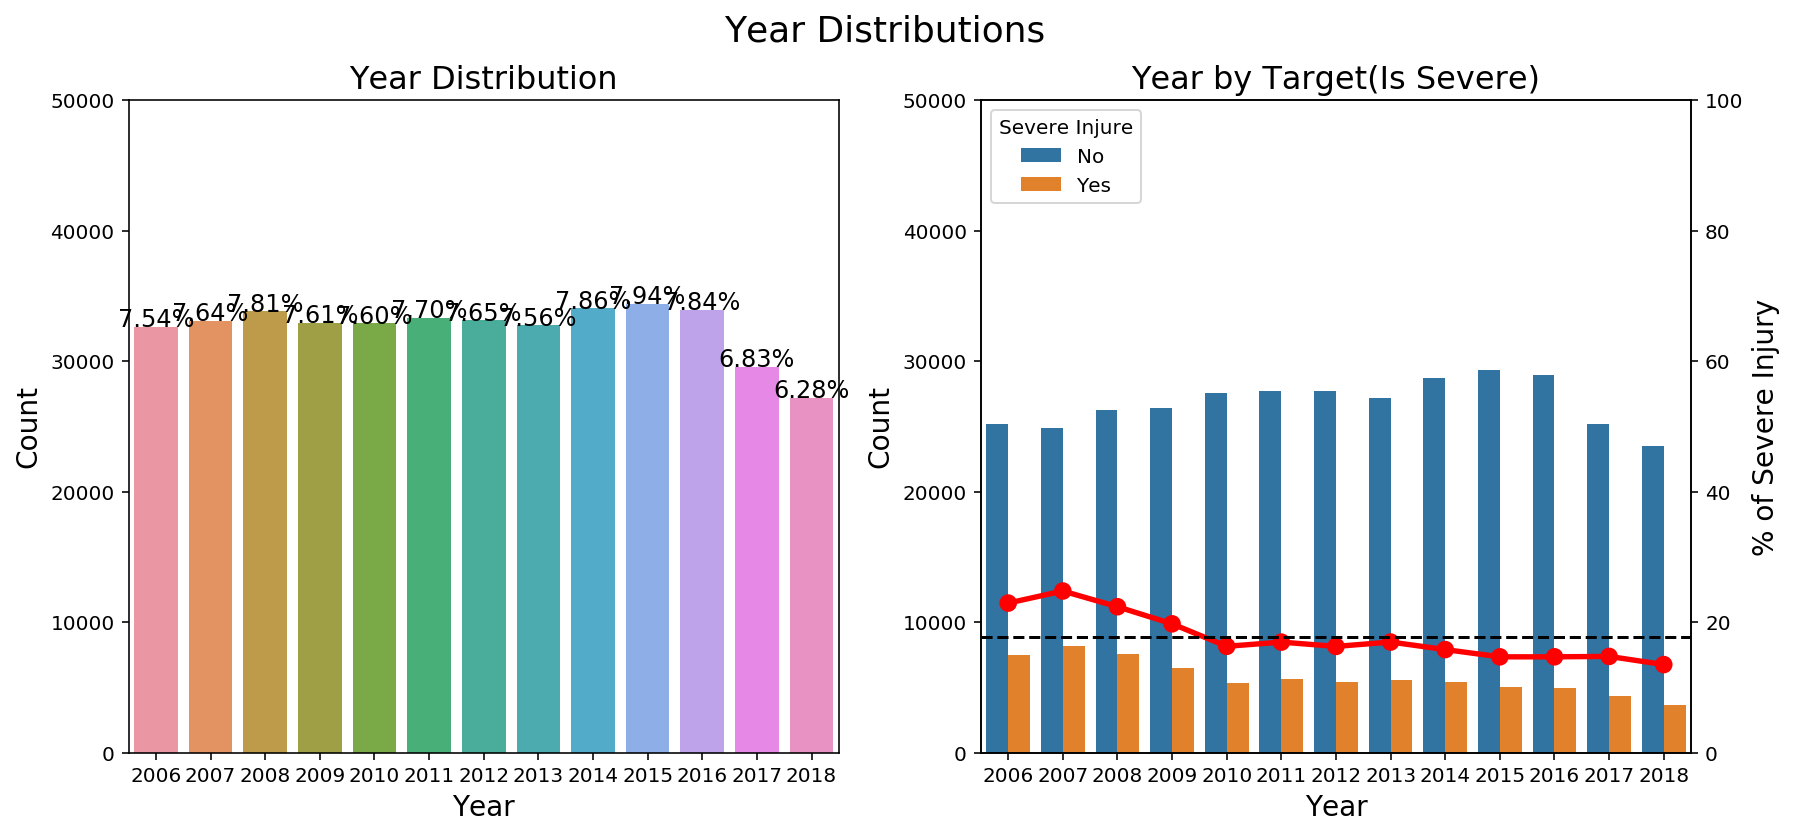

In [21]:
# year analysis
display_order = ['2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

feature = 'year'
feature_label = 'Year'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,50000],legend_position=2)

In [22]:
# remove data before the year 2010
# accident_belt = accident_belt[~accident_belt['year'].isin(['2006','2007','2008','2009'])]
accident_belt = accident_belt[accident_belt['year'].isin(['2019','2018','2017'])]
accident_belt.shape

(66020, 101)

In [23]:
# calculate the baseline
no_total_psn = accident_belt.shape[0]
no_sev_inj_psn = accident_belt.is_sev_inj.sum()
no_other_psn = no_total_psn - no_sev_inj_psn
pct_sev_inj_psn = no_sev_inj_psn/no_total_psn*100
print('Total person number (Belt/Helmet on): ',no_total_psn)
print('Total severe injury person number (Belt/Helmet on):', no_sev_inj_psn)
print(pct_sev_inj_psn, '% of the persons who use Belt/Helmet get severe injury (after 2010)')

Total person number (Belt/Helmet on):  66020
Total severe injury person number (Belt/Helmet on): 9414
14.259315358982128 % of the persons who use Belt/Helmet get severe injury (after 2010)


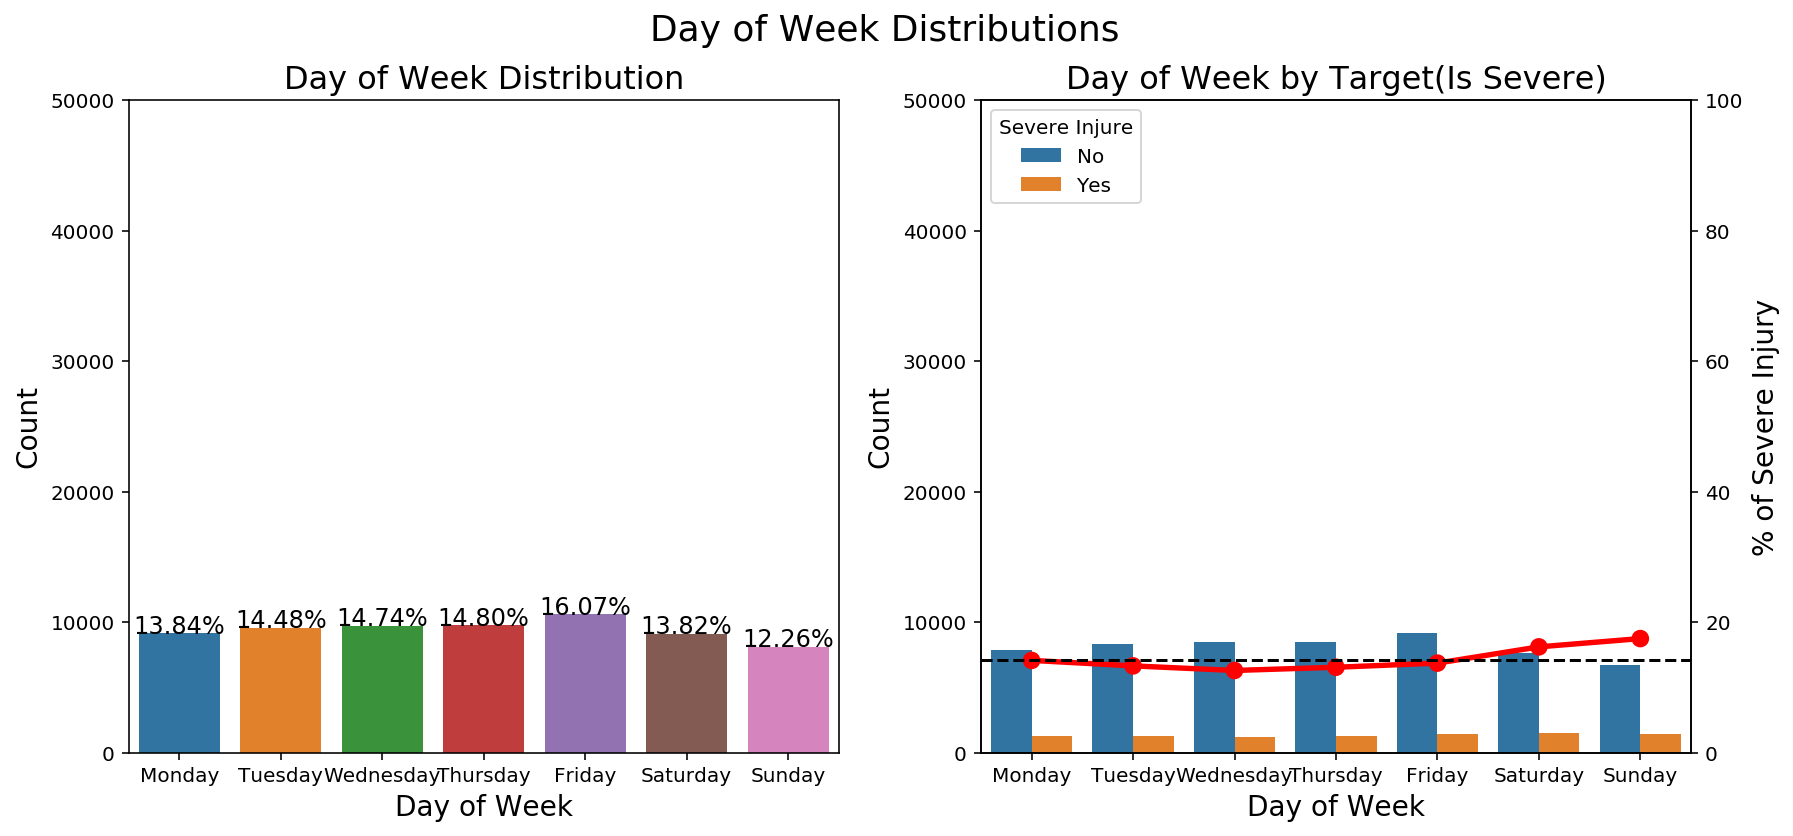

In [24]:
# day of week analysis
display_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

feature = 'day_week_description'
feature_label = 'Day of Week'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,50000],legend_position=2)

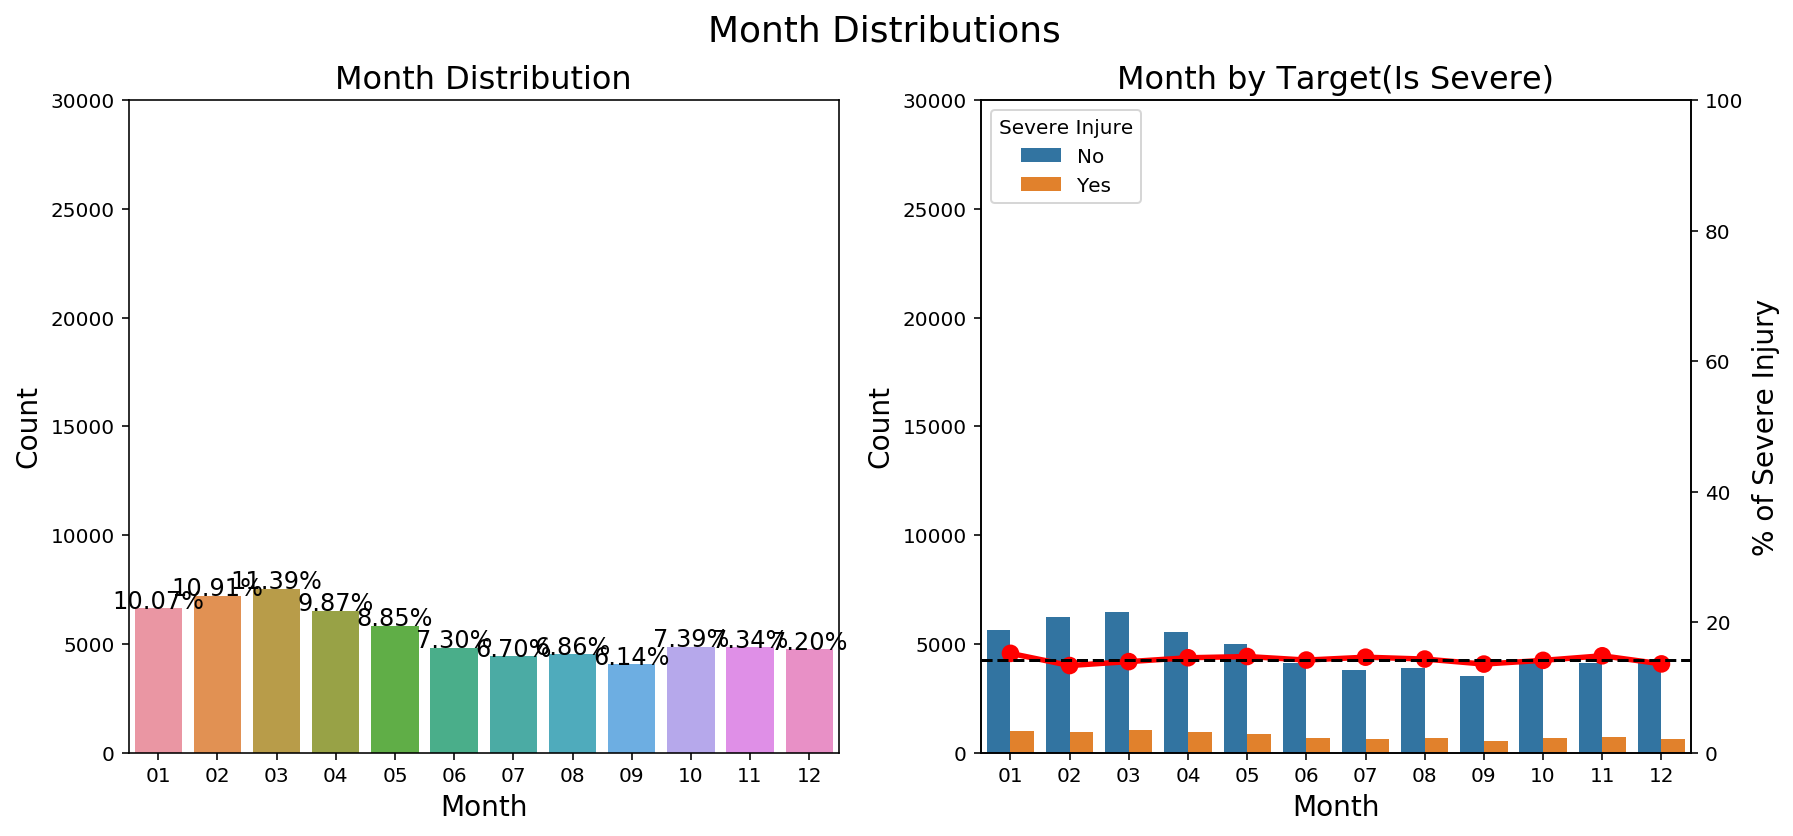

In [25]:
# month analysis
display_order = ['01','02','03','04','05','06','07','08','09','10','11','12'] # 12 months
feature = 'month'
feature_label = 'Month'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,30000],legend_position=2)

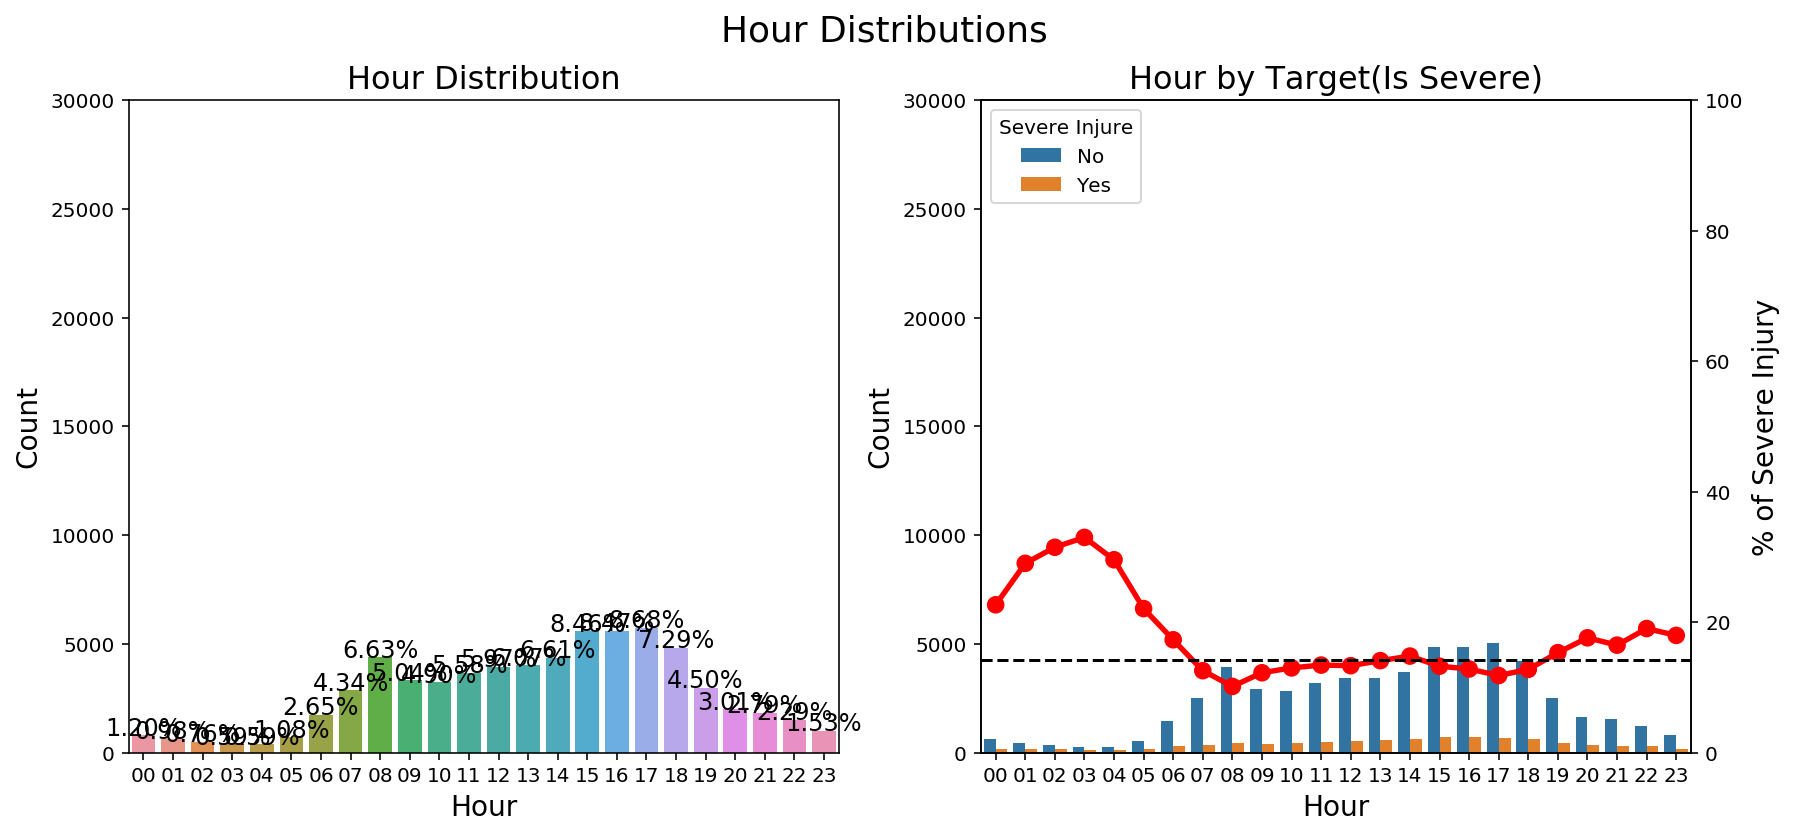

In [26]:
# hour analysis
display_order = ['00','01','02','03','04','05','06','07','08','09','10','11','12',
                 '13','14','15','16','17','18','19','20','21','22','23'] # 24 hours
feature = 'hour'
feature_label = 'Hour'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,30000],legend_position=2)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


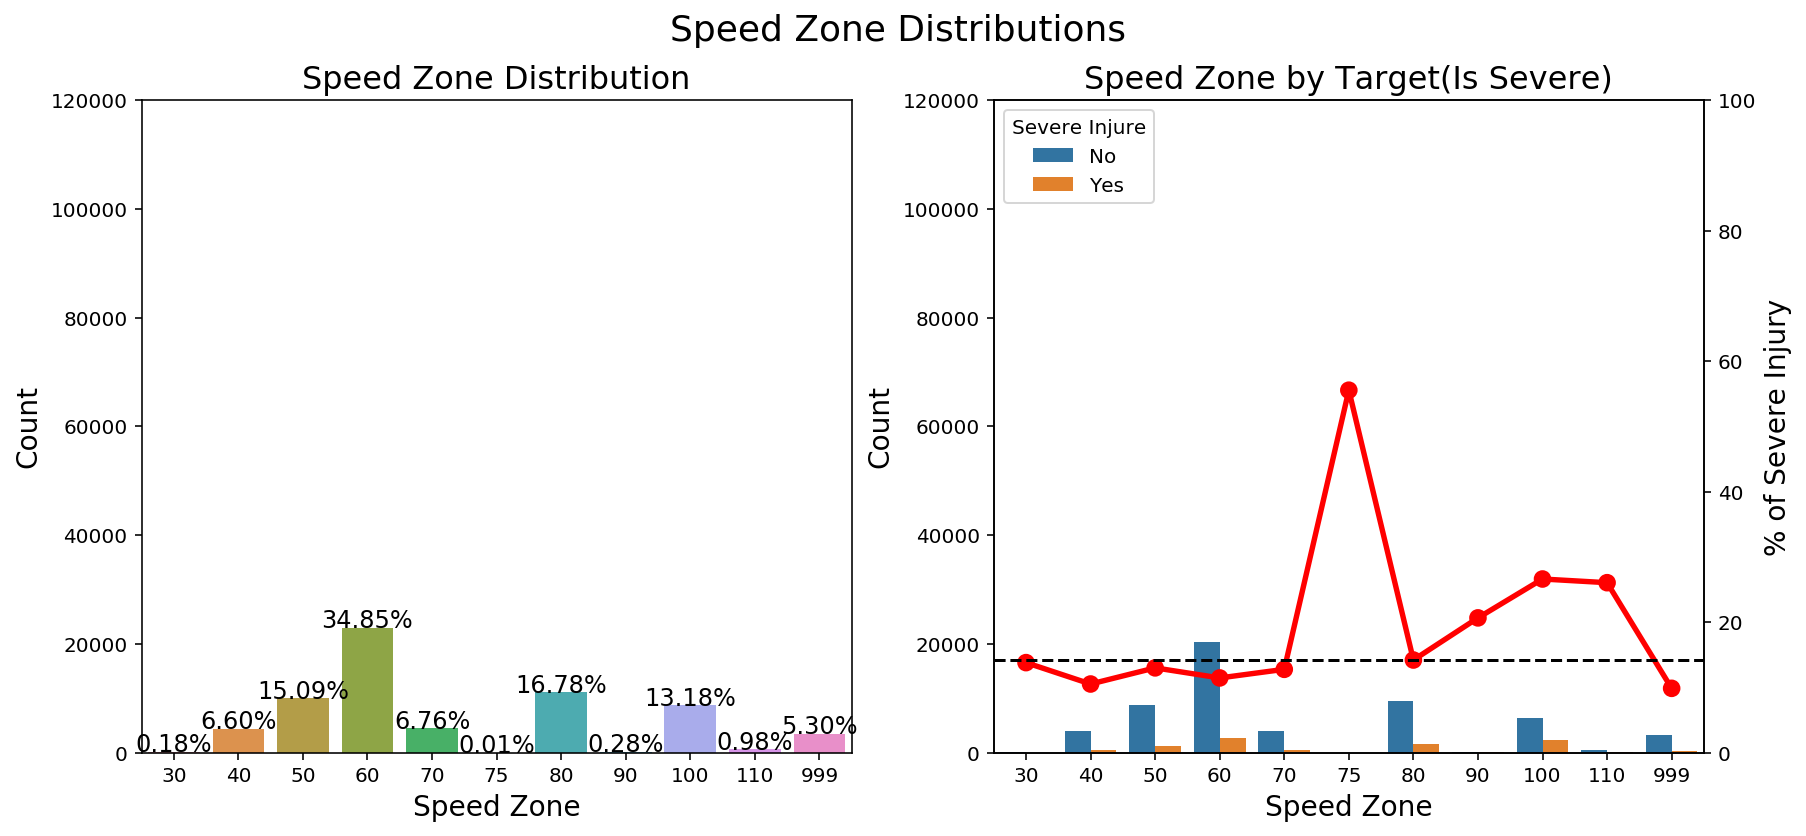

In [27]:
accident_belt['speed_zone'] = accident_belt['speed_zone'].astype(str)
# speed zone analysis
display_order = ['30','40','50','60','70','75','80','90','100','110','999'] 
feature = 'speed_zone'
feature_label = 'Speed Zone'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,120000],legend_position=2)

In [28]:
dict_light_cond_desc = {'Day':'Day','Dusk/Dawn':'Dusk/Dawn','Dark Street lights on':'LightOn',
                       'Dark Street lights off':'LightOff','Dark No street lights':'NoLight',
                       'Dark Street lights unknown':'LightUn','Unknown':'Unknown'}
accident_belt['light_condition_desc'] = accident_belt['light_condition_desc'].map(lambda x: dict_light_cond_desc[x])

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


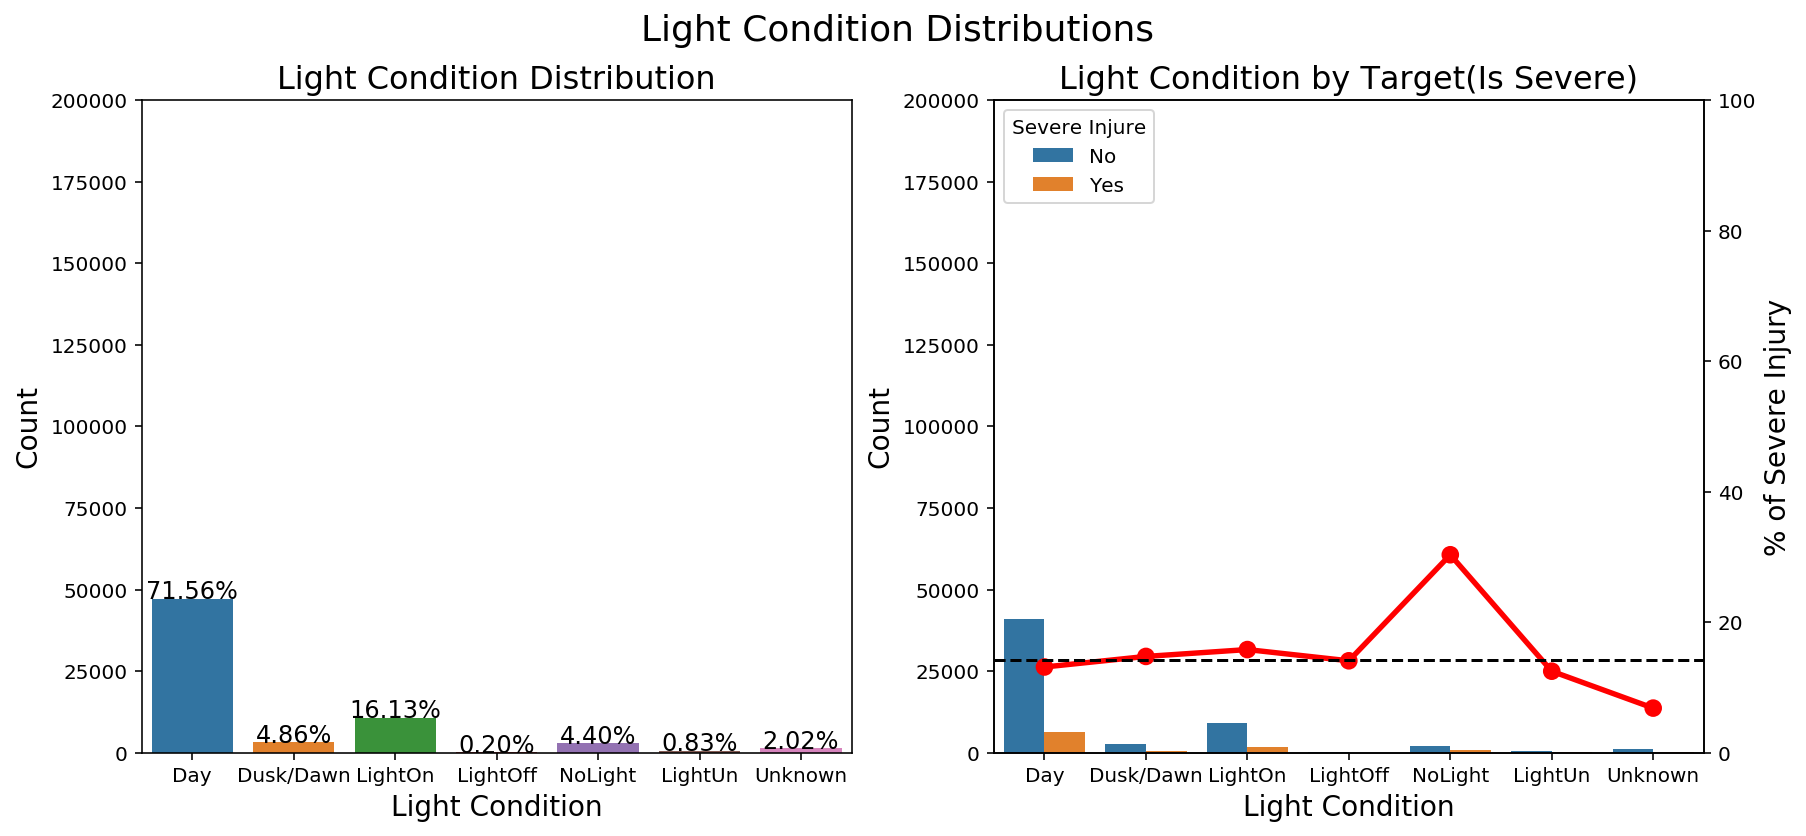

In [29]:
# light condition analysis
display_order = ['Day','Dusk/Dawn','LightOn','LightOff','NoLight','LightUn','Unknown'] 
feature = 'light_condition_desc'
feature_label = 'Light Condition'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,200000],legend_position=2)

In [30]:
dict_geo_cond_desc = {'Not at intersection':'Road','T intersection':'T','Y intersection':'Y',
                       'Cross intersection':'X','Multiple intersection':'Mul','Dead end':'End',
                       'Private property':'Property','Road closure':'Close','Unknown':'Unknown'}
accident_belt['road_geometry_desc'] = accident_belt['road_geometry_desc'].map(lambda x: dict_geo_cond_desc[x])

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


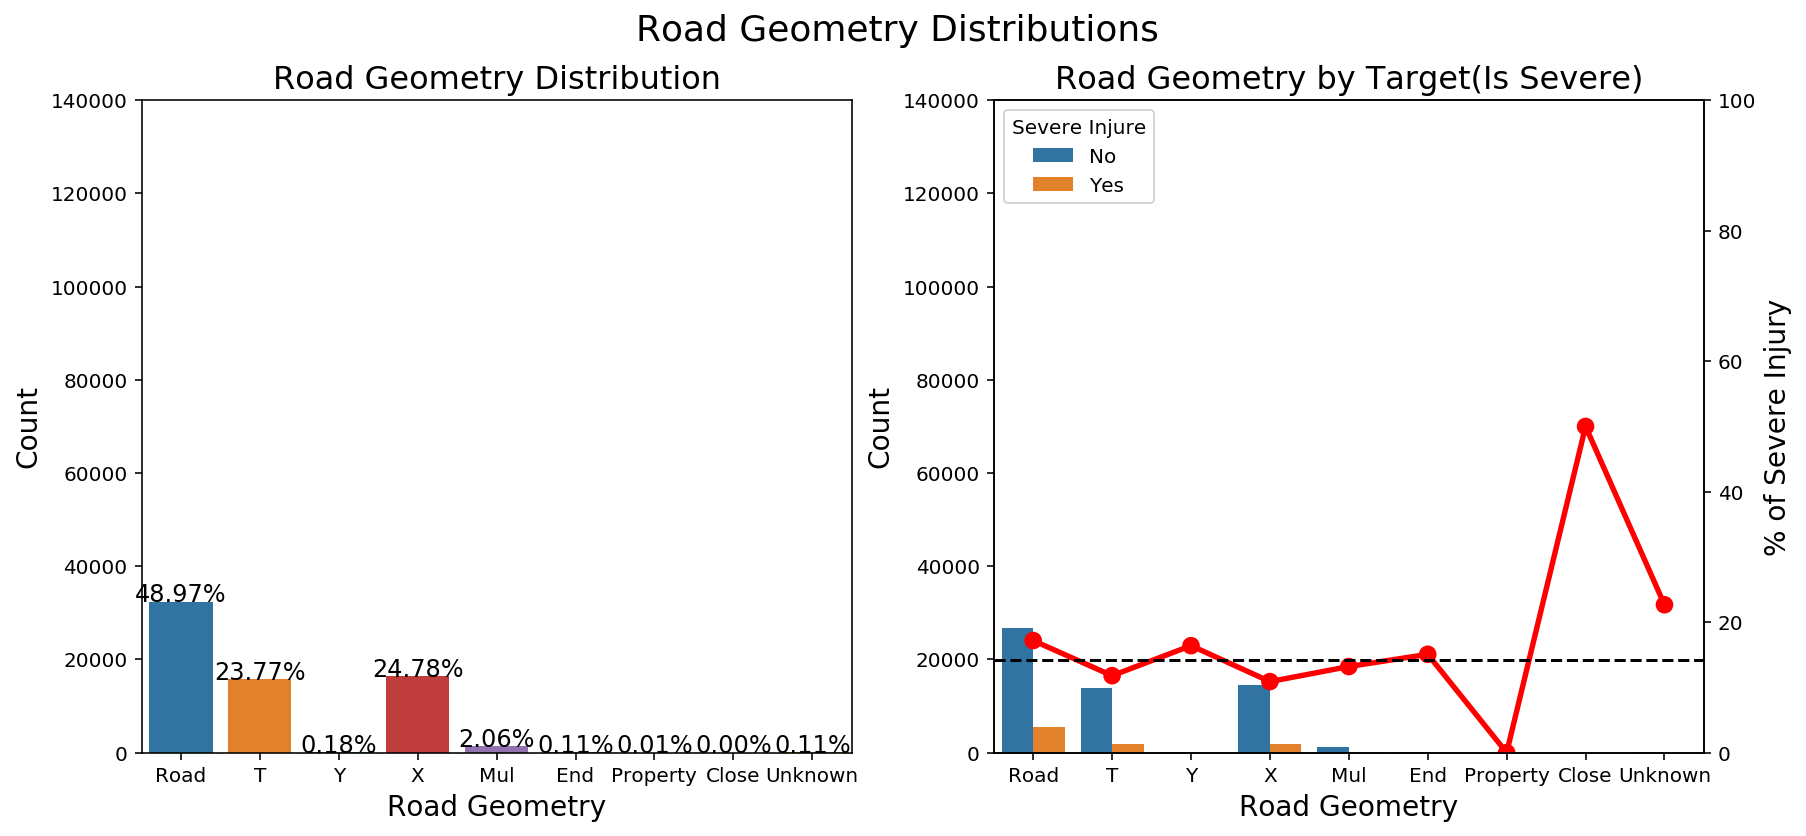

In [31]:
# road_condition analysis
display_order = ['Road','T','Y','X','Mul','End','Property','Close','Unknown'] 
feature = 'road_geometry_desc'
feature_label = 'Road Geometry'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,140000],legend_position=2)

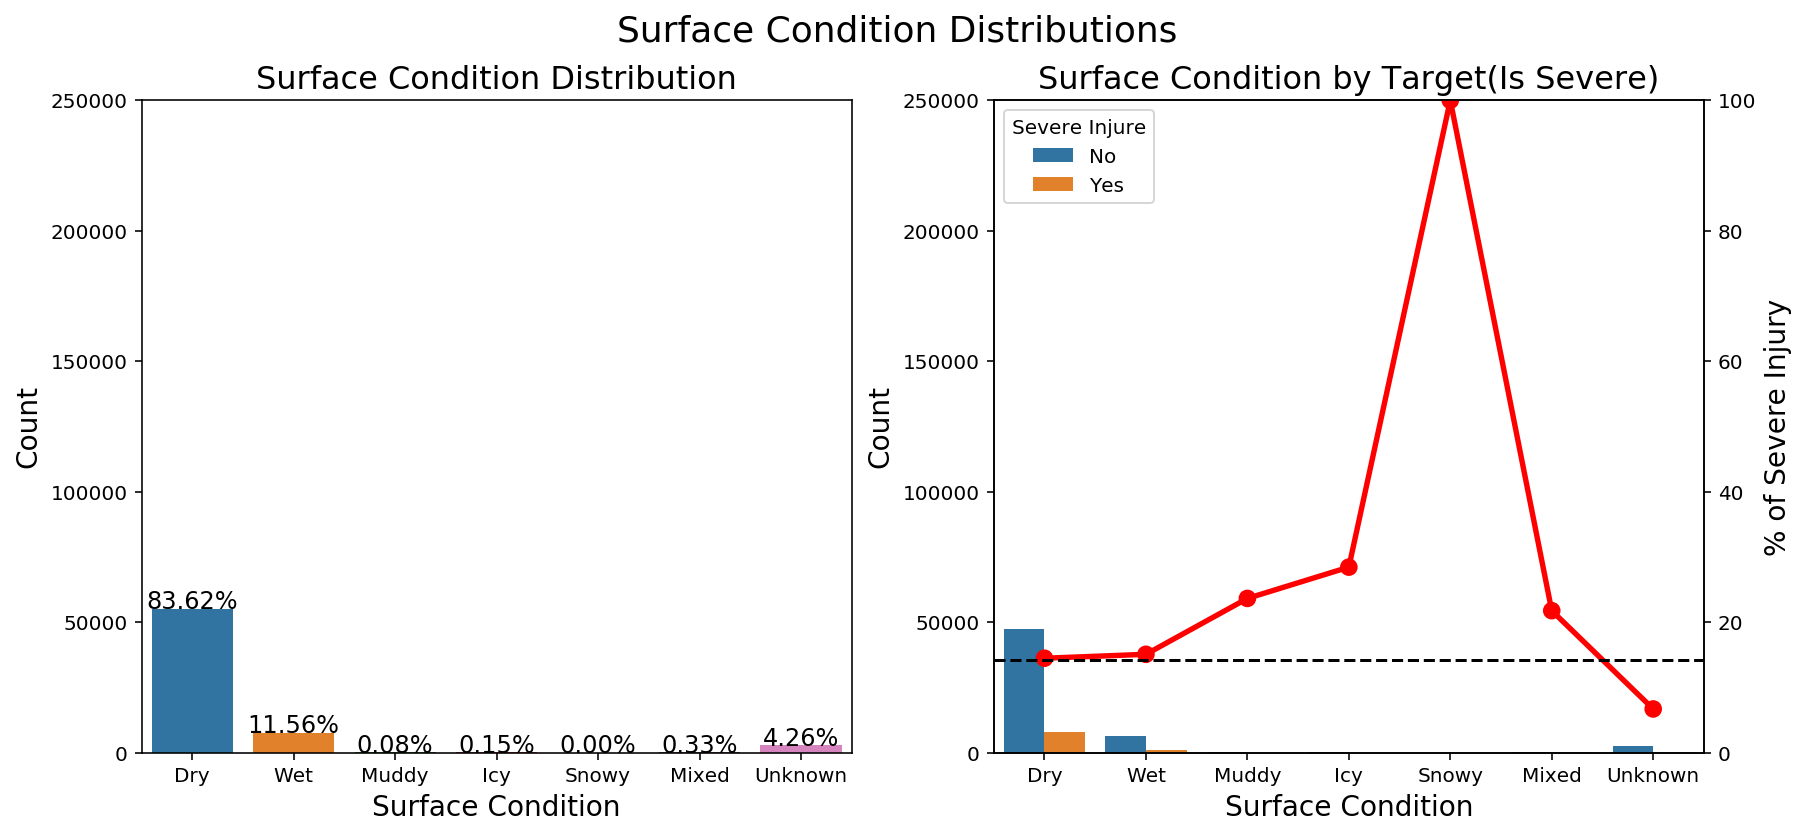

In [32]:
# surface condition analysis
display_order = ['Dry','Wet','Muddy','Icy','Snowy','Mixed','Unknown'] 
feature = 'surface_cond_desc'
feature_label = 'Surface Condition'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,250000],legend_position=2)

In [33]:
dict_atm_cond_desc = {'Clear':'Clear','Raining':'Raining','Fog':'Fog','Strong winds':'Winds','Dust':'Dust',
                      'Smoke':'Smoke','Snowing':'Snowing','Mixed':'Mixed','Not known':'Unknown'}
accident_belt['atmosph_cond_desc'] = accident_belt['atmosph_cond_desc'].map(lambda x: dict_atm_cond_desc[x])

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


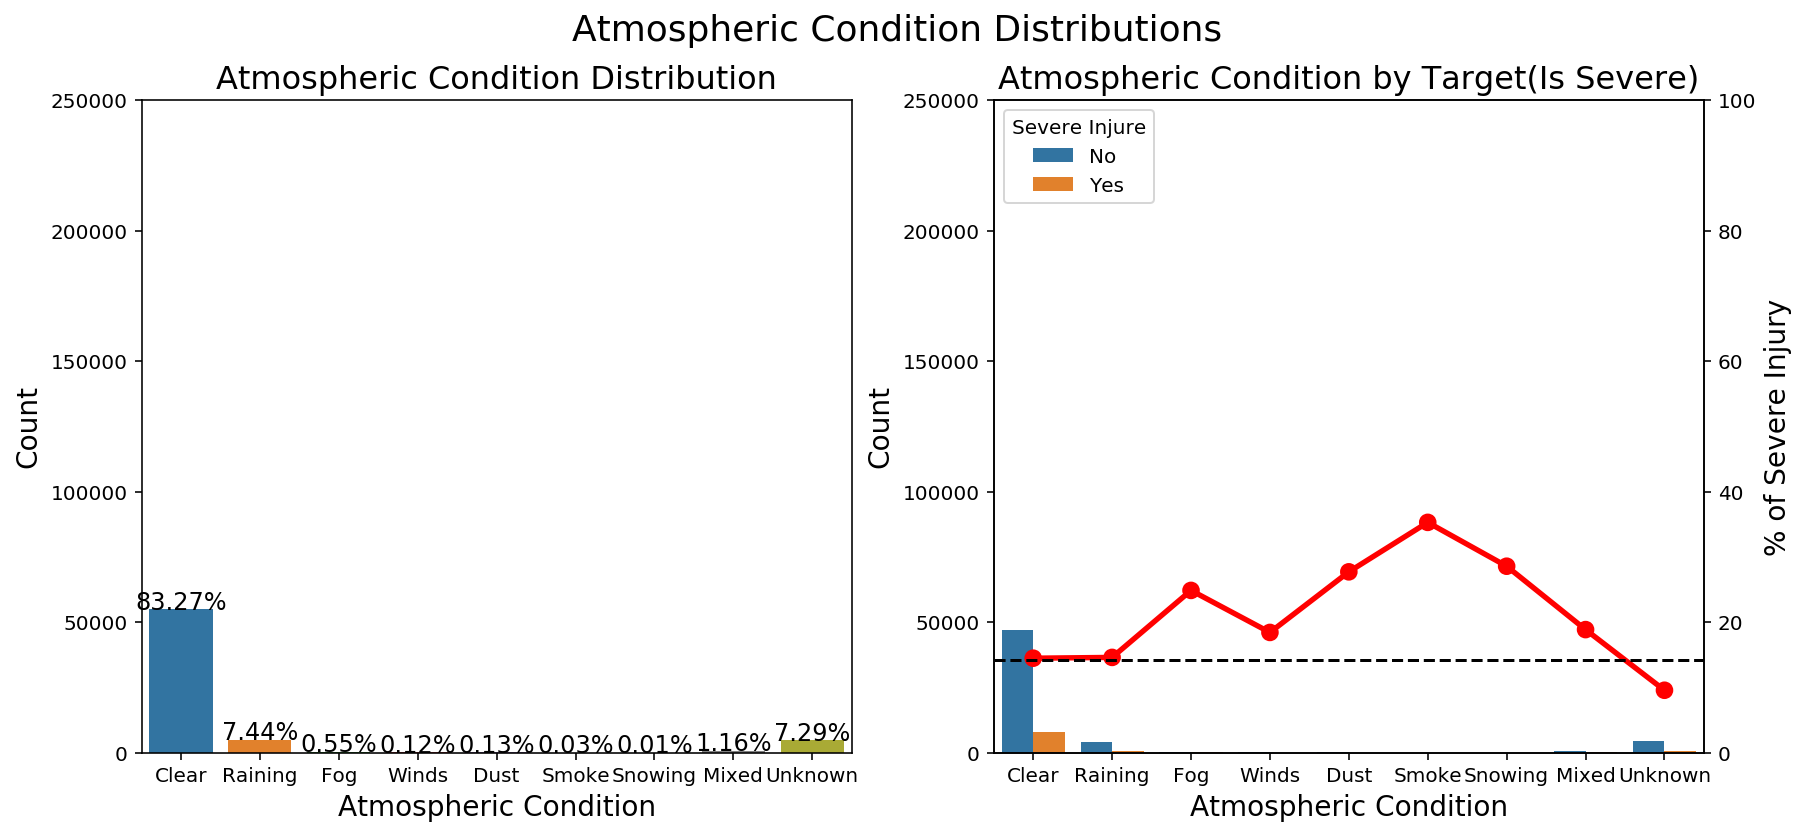

In [34]:
# atmosphric condition analysis
display_order = ['Clear','Raining','Fog','Winds','Dust','Smoke','Snowing','Mixed','Unknown'] 
feature = 'atmosph_cond_desc'
feature_label = 'Atmospheric Condition'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,250000],legend_position=2)

In [35]:
accident_belt.road_user_type_desc.value_counts()

Drivers               40260
Passengers            13810
Motorcyclists          4223
Bicyclists             3011
Pedestrians            2995
Unknown                1553
Pillion Passengers      168
Name: road_user_type_desc, dtype: int64

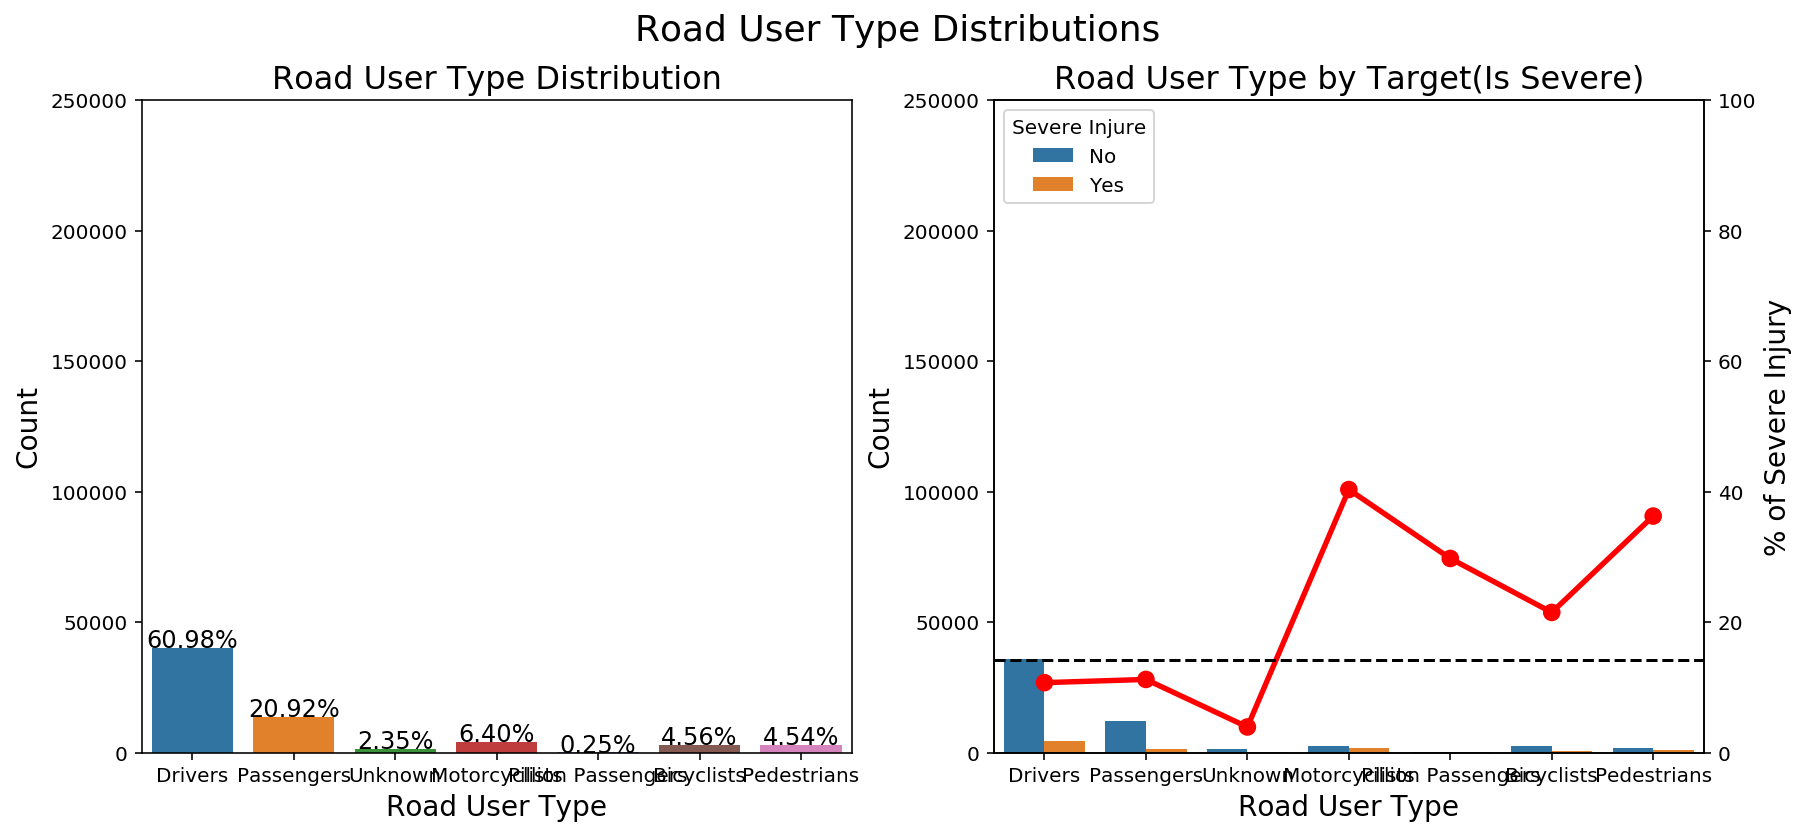

In [36]:
# atmosphric condition analysis
display_order = accident_belt.road_user_type_desc.unique()
feature = 'road_user_type_desc'
feature_label = 'Road User Type'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,250000],legend_position=2)

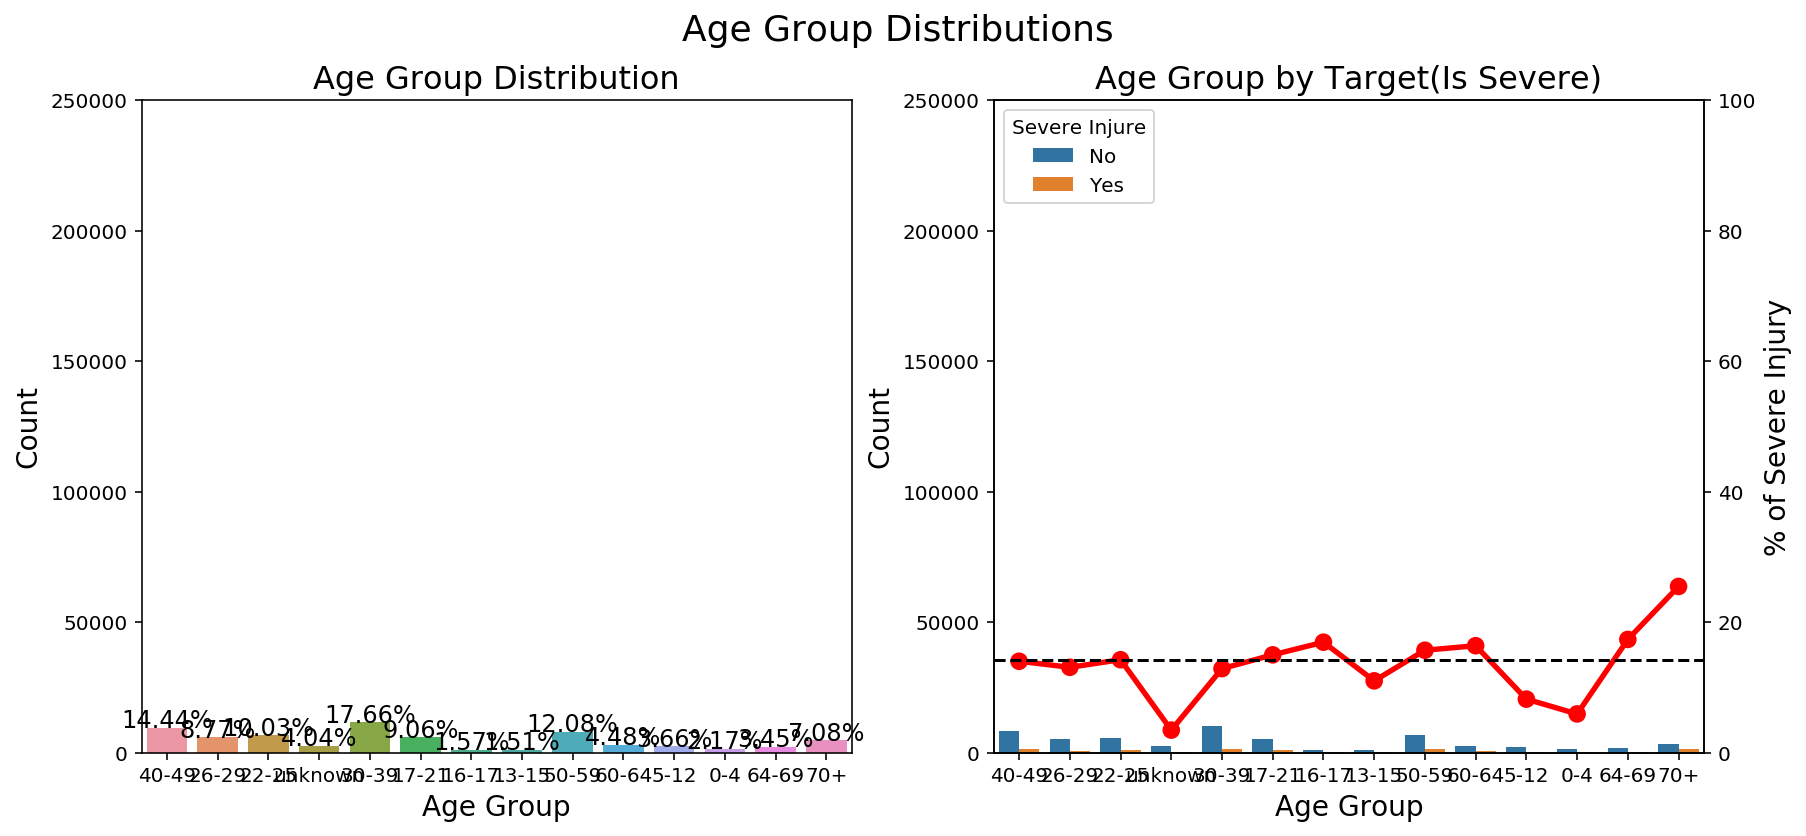

In [37]:
# atmosphric condition analysis
display_order = accident_belt.age_group.unique()
feature = 'age_group'
feature_label = 'Age Group'
plt_feature(accident_belt,feature,feature_label,no_total_psn,pct_sev_inj_psn,ylim=[0,250000],legend_position=2)

In [38]:
# out_put to csv to save selected 
accident_belt.to_csv('./selected_data.csv',index=False)

# 2. Feature Selection and Modelling

In [39]:
accident_belt.shape

(66020, 101)

In [40]:
print(accident_belt.columns[0:25])
print(accident_belt.columns[25:50])
print(accident_belt.columns[50:75])
print(accident_belt.columns[75:])

Index(['accident_no', 'accidentdate', 'accidenttime', 'accident_type',
       'accident_type_desc', 'day_of_week', 'day_week_description', 'dca_code',
       'dca_description', 'directory', 'edition', 'page', 'grid_reference_x',
       'grid_reference_y', 'light_condition', 'light_condition_desc',
       'node_id_x', 'no_of_vehicles', 'no_persons', 'no_persons_inj_2',
       'no_persons_inj_3', 'no_persons_killed', 'no_persons_not_inj',
       'police_attend', 'road_geometry'],
      dtype='object')
Index(['road_geometry_desc', 'severity', 'speed_zone', 'hour', 'month', 'year',
       'surface_cond', 'surface_cond_desc', 'surface_cond_seq', 'atmosph_cond',
       'atmosph_cond_seq', 'atmosph_cond_desc', 'node_id_y', 'node_type',
       'amg_x', 'amg_y', 'lga_name', 'lga_name_all', 'region_name',
       'deg_urban_name', 'lat', 'long', 'postcode_no', 'person_id',
       'vehicle_id'],
      dtype='object')
Index(['sex', 'age', 'age_group', 'inj_level', 'inj_level_desc',
       'seating_

In [41]:
col_keep = ['accident_no','day_week_description','light_condition','light_condition_desc','road_geometry','road_geometry_desc',
            'speed_zone','hour','month','year','surface_cond','surface_cond_desc','atmosph_cond','atmosph_cond_desc',
            'node_type','lga_name', 'lga_name_all', 'region_name','deg_urban_name', 'lat', 'long','vehicle_id',
            'road_user_type_desc','vehicle_year_manuf','initial_direction','road_surface_type','road_surface_type_desc',
            'vehicle_body_style','vehicle_make','vehicle_model','vehicle_type','vehicle_type_desc','vehicle_colour_1',
            'vehicle_colour_2','age_group',
            'is_sev_inj']

In [42]:
acc_featured = accident_belt[col_keep]
acc_featured.shape

(66020, 36)

In [43]:
# accident_belt.seating_position.value_counts()

In [44]:
# set up values for PD on null value vehicle columns
vehicle_features = ['vehicle_year_manuf','initial_direction','road_surface_type','road_surface_type_desc','vehicle_body_style','vehicle_make','vehicle_model','vehicle_type','vehicle_type_desc','vehicle_colour_1','vehicle_colour_2']
acc_featured.loc[acc_featured['vehicle_id']=='PD',vehicle_features] = ['PD']*11

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [45]:
acc_featured.vehicle_year_manuf = acc_featured.vehicle_year_manuf.astype(str)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [152]:
# 
columns=['road_user_type_desc','hour','speed_zone','atmosph_cond_desc','day_week_description','surface_cond_desc','light_condition_desc','road_geometry_desc','lga_name'
         ,'is_sev_inj','year']
acc_featured_selected = acc_featured[columns]
acc_featured_selected.columns

Index(['road_user_type_desc', 'hour', 'speed_zone', 'atmosph_cond_desc',
       'day_week_description', 'surface_cond_desc', 'light_condition_desc',
       'road_geometry_desc', 'lga_name', 'is_sev_inj', 'year'],
      dtype='object')

In [153]:
acc_featured_selected = acc_featured_selected[~(acc_featured_selected['speed_zone'] == '999')]
acc_featured_selected = acc_featured_selected[~(acc_featured_selected['road_user_type_desc'] == 'Unknown')]
acc_featured_selected['user'] = acc_featured_selected.road_user_type_desc.map(lambda x: 'Car' if x in ['Drivers','Passengers'] else ( 'Motercycle' if x in ['Motorcyclists','Pillion Passengers'] else x))


In [154]:
# acc_featured_selected.lga_name.value_counts()

MELBOURNE               3352
CASEY                   2992
GEELONG                 2639
DANDENONG               2190
HUME                    2162
WHITTLESEA              1948
BRIMBANK                1937
MONASH                  1849
MORELAND                1837
KINGSTON                1593
YARRA RANGES            1548
DAREBIN                 1500
WYNDHAM                 1476
WHITEHORSE              1355
YARRA                   1345
KNOX                    1343
MORNINGTON PENINSULA    1326
BOROONDARA              1304
GLEN EIRA               1290
BALLARAT                1223
BENDIGO                 1141
STONNINGTON             1118
PORT PHILLIP            1116
MELTON                  1105
FRANKSTON               1077
BANYULE                  995
CARDINIA                 987
MOONEE VALLEY            970
MAROONDAH                966
MANNINGHAM               892
                        ... 
GLENELG                  195
SWAN HILL                188
HORSHAM                  182
HEPBURN       

In [155]:
# selected_lga = ['MELBOURNE','CASEY','GEELONG','DANDENONG','HUME']
# # accident_belt['atmosph_cond_desc'] = accident_belt['atmosph_cond_desc'].map(lambda x: dict_atm_cond_desc[x])
# acc_featured_selected['lga_name'] = acc_featured_selected.lga_name.map(lambda x: x if x in selected_lga else 'OTHER')
# acc_featured_selected = acc_featured_selected[~(acc_featured_selected.lga_name == 'OTHER')]

In [156]:
#'road_geometry_desc',,'light_condition_desc','surface_cond_desc','lga_name','atmosph_cond_desc''day_week_description',
acc_featured_enc = pd.get_dummies(acc_featured_selected, columns=['user','hour','speed_zone','atmosph_cond_desc','day_week_description','surface_cond_desc','light_condition_desc','road_geometry_desc','lga_name'
                                                                 ])
acc_featured_enc.drop('road_user_type_desc',axis=1,inplace=True)

In [157]:
acc_featured_enc.columns

Index(['is_sev_inj', 'year', 'user_Bicyclists', 'user_Car', 'user_Motercycle',
       'user_Pedestrians', 'hour_00', 'hour_01', 'hour_02', 'hour_03',
       'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'speed_zone_100', 'speed_zone_110',
       'speed_zone_30', 'speed_zone_40', 'speed_zone_50', 'speed_zone_60',
       'speed_zone_70', 'speed_zone_75', 'speed_zone_80', 'speed_zone_90',
       'atmosph_cond_desc_Clear', 'atmosph_cond_desc_Dust',
       'atmosph_cond_desc_Fog', 'atmosph_cond_desc_Mixed',
       'atmosph_cond_desc_Raining', 'atmosph_cond_desc_Unknown',
       'atmosph_cond_desc_Winds', 'day_week_description_Friday',
       'day_week_description_Monday', 'day_week_description_Saturday',
       'day_week_description_Sunday', 'day_week_description_Thursday',
       'day_week_descript

In [158]:
acc_featured_train = acc_featured_enc[acc_featured_enc['year'] != '2019']
acc_featured_test = acc_featured_enc[acc_featured_enc['year'] == '2019']
# acc_featured_train = acc_featured_enc[~acc_featured_enc['year'].isin(['2019','2018'])]
# acc_featured_test = acc_featured_enc[acc_featured_enc['year'].isin(['2019','2018'])]
# oversampling severe injury data to 50%
# acc_train_osmp = over_sample(acc_featured_train,feature='is_sev_inj',f_value=1,percent=0.5)
# acc_test_osmp = over_sample(acc_featured_test,feature='is_sev_inj',f_value=1,percent=0.5)

# print(acc_featured_train.shape)
# print(acc_train_osmp.shape)
# print(acc_train_osmp[acc_train_osmp.is_sev_inj == 1].shape)
# print(acc_featured_test.shape)


In [159]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
# acc_featured['day_week'] = le.transform(acc_featured['day_week_description'])

# acc_featured['lga_code'] = le.fit_transform(acc_featured['lga_name']) # _all
# acc_featured['age_group_code'] = le.fit_transform(acc_featured['age_group'])
# acc_featured['user_type'] = le.fit_transform(acc_featured['road_user_type_desc'])

# acc_featured['sur_type'] = le.fit_transform(acc_featured['road_surface_type_desc'])

# acc_featured['veh_type'] = le.fit_transform(acc_featured['vehicle_type_desc'])
# acc_featured['bdy_type'] = le.fit_transform(acc_featured['vehicle_body_style'])

# acc_featured['veh_clr'] = le.fit_transform(acc_featured['vehicle_colour_1'])
# acc_featured['veh_clr2'] = le.fit_transform(acc_featured['vehicle_colour_2'])

# acc_featured['veh_mke'] = le.fit_transform(acc_featured['vehicle_make'])
# acc_featured['veh_mdl'] = le.fit_transform(acc_featured['vehicle_model'])
# acc_featured['veh_type'] = le.fit_transform(acc_featured['vehicle_type_desc'])
# acc_featured['ini_dir'] = le.fit_transform(acc_featured['initial_direction'])
# acc_featured['veh_year'] = le.fit_transform(acc_featured['vehicle_year_manuf'])

In [160]:
# Over Sampling

# Sampling data 
def sample_df(df,size,seed=818,replace=True):
    np.random.seed = seed
    indices = np.random.choice(df.shape[0], size,replace=replace)
    sample = df.iloc[indices,:]
    sample.reset_index(drop=True,inplace=True)
    return sample

# over sampling for the class have less data
def over_sample(df,feature,f_value,percent=0.5):
    target_df = df[df[feature]==f_value]
    other_df = df[df[feature]!=f_value]
    other_size = other_df.shape[0]
    target_size = int(other_size/(1-percent)) - other_size # calculate target sample size based on percentage
    over_sample_df = sample_df(target_df,size=target_size)
    return pd.concat([over_sample_df,other_df],ignore_index=True)


In [161]:
# acc_featured_train = acc_featured[acc_featured['year'] != '2019']
# acc_featured_test = acc_featured[acc_featured['year'] == '2019']
# # acc_featured_train = acc_featured[~acc_featured['year'].isin(['2019','2018'])]
# # acc_featured_test = acc_featured[acc_featured['year'].isin(['2019','2018'])]
# # oversampling severe injury data to 50%
# acc_train_osmp = over_sample(acc_featured_train,feature='is_sev_inj',f_value=1,percent=0.5)
# acc_test_osmp = over_sample(acc_featured_test,feature='is_sev_inj',f_value=1,percent=0.5)

# print(acc_featured_train.shape)
# print(acc_train_osmp.shape)
# print(acc_train_osmp[acc_train_osmp.is_sev_inj == 1].shape)
# print(acc_featured_test.shape)


In [162]:
acc_train_osmp = over_sample(acc_featured_train,feature='is_sev_inj',f_value=1,percent=0.5)
# acc_test_osmp = over_sample(acc_featured_test,feature='is_sev_inj',f_value=1,percent=0.5)
y_test = acc_featured_test['is_sev_inj']
X_test = acc_featured_test.drop(columns=['is_sev_inj','year'],axis=1)

X_train = acc_train_osmp.drop(columns=['is_sev_inj','year'],axis=1)
y_train = acc_train_osmp['is_sev_inj']
X_train.shape

(19928, 78)

In [163]:
# #'veh_year','veh_mdl','veh_clr','veh_clr2',
# features = ['user_type','lga_code','day_week','hour','month','speed_zone','light_condition','road_geometry','surface_cond','atmosph_cond']
# # X_train = acc_featured_train[features]
# # y_train = acc_featured_train['is_sev_inj']
# X_test = acc_featured_test[features]
# y_test = acc_featured_test['is_sev_inj']

# # # over sampling
# X_train = acc_train_osmp[features]
# y_train = acc_train_osmp['is_sev_inj']

# # # # over sampling test data for performance evaluation
# # X_test = acc_test_osmp[features]
# # y_test = acc_test_osmp['is_sev_inj']

In [164]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# 50%
classifier = RandomForestClassifier() # criterion='entropy',
classifier.fit(X_train, y_train)
y_pre = classifier.predict(X_test)
# print(np.mean(cross_val_score(classifier, X_train, y_train, cv=5)))
# confusion_matrix(y_test, y_pre)
confusion = pd.crosstab(y_test, y_pre, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print(classification_report(y_test, y_pre))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predicted     0    1   All
Actual                    
0          1469  197  1666
1           165   67   232
All        1634  264  1898
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1666
           1       0.25      0.29      0.27       232

   micro avg       0.81      0.81      0.81      1898
   macro avg       0.58      0.59      0.58      1898
weighted avg       0.82      0.81      0.81      1898



In [107]:
# #Gridsearching

# params = {
#     'max_depth':np.arange(5, 15, 1),
#     'criterion':['gini','entropy'],
#     'n_estimators':np.arange(5, 15, 1)
# }
# gscv = GridSearchCV(RandomForestClassifier(), params, cv=5, verbose=1,n_jobs=-1)

In [108]:
# gscv.fit(X_train, y_train)
# gscv.best_score_

In [109]:
# [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
# [Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 29.3min finished

In [110]:
# gscv.best_params_

In [111]:
#{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 8}

In [112]:
# best_model = gscv.best_estimator_
# best_model.score(X_test, y_test)

In [113]:
# 0.7240514982340207

In [165]:
# 50%
classifier = RandomForestClassifier(criterion='gini',max_depth=10, n_estimators=100) 
classifier.fit(X_train, y_train)
y_pre = classifier.predict(X_test)
# confusion_matrix(y_test, y_pre)
confusion = pd.crosstab(y_test, y_pre, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print(classification_report(y_test, y_pre))

Predicted     0    1   All
Actual                    
0          1369  297  1666
1           126  106   232
All        1495  403  1898
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1666
           1       0.26      0.46      0.33       232

   micro avg       0.78      0.78      0.78      1898
   macro avg       0.59      0.64      0.60      1898
weighted avg       0.84      0.78      0.80      1898



In [166]:
# proba = classifier.predict_proba(X_test).T
# # y_pred = logreg_cv.predict(X_test)
# y_pred = pd.DataFrame()
# y_pred['actual'] = y_test

# y_pred['proba_0'] = proba[0]
# y_pred['proba_1'] = proba[1]
# pct = pct_sev_inj_psn/100

# y_pred['predict'] = [1 if x >= 0.50 else 0 for x in y_pred.proba_1.values]
# confusion_matrix(y_test, y_pred['predict'])
# confusion = pd.crosstab(y_test, y_pred['predict'], rownames=['Actual'], colnames=['Predicted'], margins=True)
# print(confusion)
# print(classification_report(y_test, y_pred['predict']))

Predicted     0    1   All
Actual                    
0          1369  297  1666
1           126  106   232
All        1495  403  1898
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1666
           1       0.26      0.46      0.33       232

   micro avg       0.78      0.78      0.78      1898
   macro avg       0.59      0.64      0.60      1898
weighted avg       0.84      0.78      0.80      1898



In [167]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
classifier = AdaBoostClassifier() 
classifier.fit(X_train, y_train)
y_pre = classifier.predict(X_test)
# confusion_matrix(y_test, y_pre)
confusion = pd.crosstab(y_test, y_pre, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print(classification_report(y_test, y_pre))

Predicted     0    1   All
Actual                    
0          1210  456  1666
1            94  138   232
All        1304  594  1898
              precision    recall  f1-score   support

           0       0.93      0.73      0.81      1666
           1       0.23      0.59      0.33       232

   micro avg       0.71      0.71      0.71      1898
   macro avg       0.58      0.66      0.57      1898
weighted avg       0.84      0.71      0.76      1898



In [168]:
classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),n_estimators=200)
classifier.fit(X_train, y_train)
y_pre = classifier.predict(X_test)
# confusion_matrix(y_test, y_pre)
confusion = pd.crosstab(y_test, y_pre, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print(classification_report(y_test, y_pre))

Predicted     0    1   All
Actual                    
0          1206  460  1666
1           105  127   232
All        1311  587  1898
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1666
           1       0.22      0.55      0.31       232

   micro avg       0.70      0.70      0.70      1898
   macro avg       0.57      0.64      0.56      1898
weighted avg       0.83      0.70      0.75      1898



In [169]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)
y_pre = classifier.predict(X_test)
# confusion_matrix(y_test, y_pre)
confusion = pd.crosstab(y_test, y_pre, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print(classification_report(y_test, y_pre))

Predicted     0    1   All
Actual                    
0          1284  382  1666
1            90  142   232
All        1374  524  1898
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1666
           1       0.27      0.61      0.38       232

   micro avg       0.75      0.75      0.75      1898
   macro avg       0.60      0.69      0.61      1898
weighted avg       0.85      0.75      0.79      1898



In [149]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression() 
classifier.fit(X_train, y_train)
y_pre = classifier.predict(X_test)
# confusion_matrix(y_test, y_pre)
confusion = pd.crosstab(y_test, y_pre, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print(classification_report(y_test, y_pre))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Predicted     0    1   All
Actual                    
0          1173  493  1666
1            88  144   232
All        1261  637  1898
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1666
           1       0.23      0.62      0.33       232

   micro avg       0.69      0.69      0.69      1898
   macro avg       0.58      0.66      0.57      1898
weighted avg       0.84      0.69      0.74      1898



In [ ]:
# import pickle
# pickle.dump(classifier, open('model.pkl','wb'))

In [ ]:
# X_test.to_csv('test_data.csv',index=False)

In [ ]:
# MLP
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier() 
classifier.fit(X_train, y_train)
y_pre = classifier.predict(X_test)
# confusion_matrix(y_test, y_pre)
confusion = pd.crosstab(y_test, y_pre, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print(classification_report(y_test, y_pre))

In [ ]:
# Gradient Descent
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(max_iter=1000,n_jobs=-1) 
classifier.fit(X_train, y_train)
y_pre = classifier.predict(X_test)
# confusion_matrix(y_test, y_pre)
confusion = pd.crosstab(y_test, y_pre, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
print(classification_report(y_test, y_pre))

In [ ]:
# from sklearn.svm import SVC
# classifier = SVC() # kernel='linear'
# classifier.fit(X_train, y_train)
# y_pre = classifier.predict(X_test)
# # confusion_matrix(y_test, y_pre)
# confusion = pd.crosstab(y_test, y_pre, rownames=['Actual'], colnames=['Predicted'], margins=True)
# print(confusion)
# print(classification_report(y_test, y_pre))